# Quasi-Bayesian approach on an exponential model (Simulated Data)

In [42]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [43]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
import seaborn as sns
from statsmodels import datasets
from theano import tensor as T

from construct_data import construct_data, quasi_posterior
import pandas

In [44]:
beta_true = np.array([0.15, -25])
N_train = 1000
N_test = 100
C = 100

data_train, Y_train, delta_list_train = construct_data(beta_true, N_train, C)
data_test, Y_test, delta_list_test = construct_data(beta_true, N_test, C)

#Variables Explicatives
data_train = pandas.DataFrame(data_train)
data_train = data_train.rename(index=str, columns={0: "a", 1: "b"})
data_test = pandas.DataFrame(data_test)
data_test = data_test.rename(index=str, columns={0: "a", 1: "b"})

#Death
Y_train = pandas.DataFrame(Y_train)
Y_train = Y_train.rename(index=str, columns={0: "time"})
Y_test = pandas.DataFrame(Y_test)
Y_test = Y_test.rename(index=str, columns={0: "time"})

delta_list_train = np.array(delta_list_train)
delta_list_test = np.array(delta_list_test)

In [45]:
alpha = 0.01

with pm.Model() as exponential_quasi_bayesian:
    #Regressors
    beta0 = pm.Uniform('beta0', 0, 1.)
    beta1 = pm.Uniform('beta1', -60., 0.)
    
    #beta0 = pm.Gamma('beta0', alpha= 1, beta = 10)
    #beta1 = pm.Normal('beta1', mu=beta_true[1]+2, tau=40)
    
    lambda_ = pm.Deterministic('lambda_', T.exp(beta0 * data_train.a + beta1*data_train.b))
    #Prediction
    y_hat = pm.Deterministic('y_hat', (1 - T.exp(-C*lambda_))/lambda_)
    
    #Posterior Predictive Distribution
    lambda_test = pm.Deterministic('lambda_test', T.exp(beta0 * data_test.a + beta1*data_test.b))
    y_pred = pm.Deterministic('y_pred', (1 - T.exp(-C*lambda_test))/lambda_test)
    
    def log_exp_risk(failure):
        out = ((y_hat - failure)**2).mean()
        return -alpha*out
    
    exp_surv = pm.DensityDist('exp_surv', log_exp_risk, observed={'failure':Y_train.time})
    
print("Model Created")

INFO (theano.gof.compilelock): Refreshing lock /home/victor/.theano/compiledir_Linux-4.10--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock


Model Created


In [46]:
n_samples = 60000
burn = 20000
thin = 20 #To uncorellate as much as possible the samples, we keep the sample every thin samples

with exponential_quasi_bayesian:
    step = pm.Metropolis()
    trace = pm.sample(n_samples, step)
    
trace = trace[burn::thin]

100%|██████████| 60500/60500 [00:33<00:00, 1811.27it/s]


beta0 mean a quasi posteriori :  0.256059423642
beta1 mean a quasi posteriori :  -36.9981685845


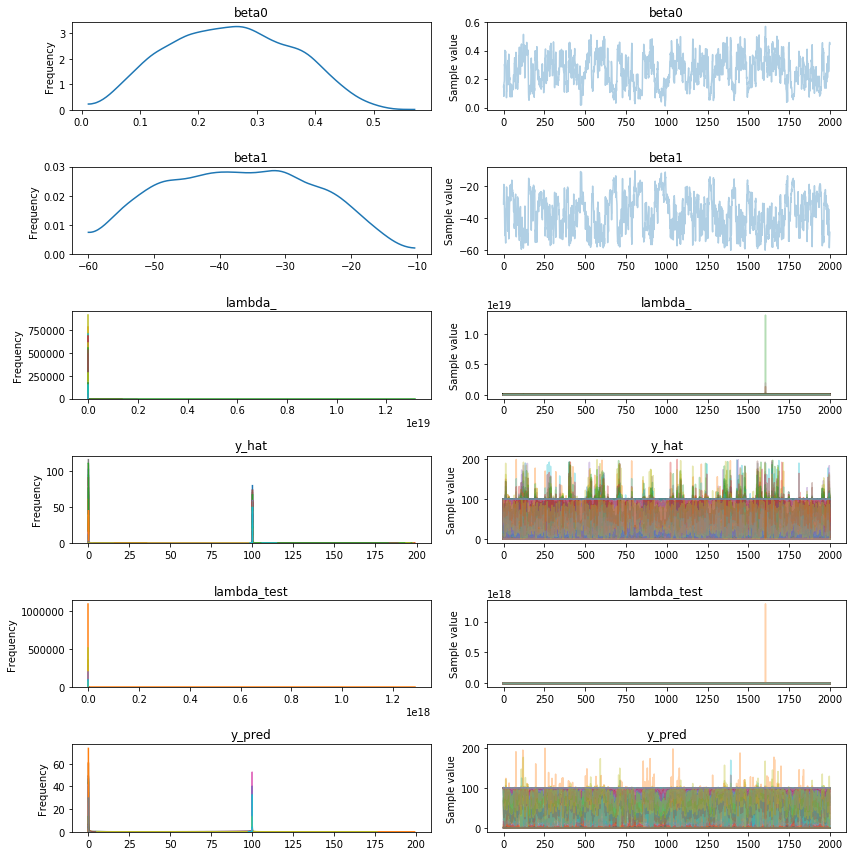

In [47]:
pm.traceplot(trace);
print("beta0 mean a quasi posteriori : ", trace['beta0'].mean())
print("beta1 mean a quasi posteriori : ", trace['beta1'].mean())

Mean Squared Error: 65.13


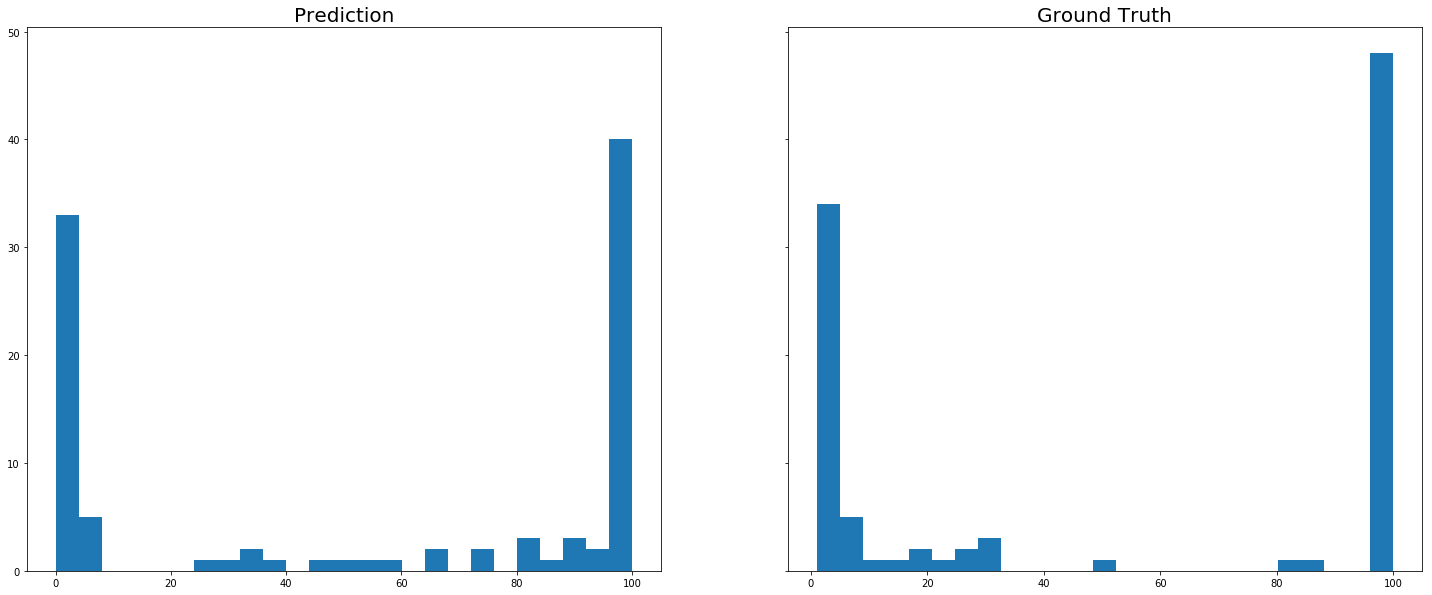

In [49]:
Y_pred = trace["y_pred"].mean(axis=0)
Y_test = np.array(Y_test)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10), sharey = True)
ax1.hist(Y_pred, bins = 25)
ax1.set_title('Prediction', fontsize= 20)

ax2.hist(Y_test, bins = 25)
ax2.set_title('Ground Truth', fontsize= 20)

print("Mean Squared Error: %0.2f" % np.sqrt(((Y_test - Y_pred)**2).mean()))

### Temperature Parameter considered as random variable (included in the inference)

In [7]:
with pm.Model() as exponential_quasi_bayesian_alpha:
    #Regressors
    #beta0 = pm.Uniform('beta0', -1., 1.)
    beta1 = pm.Uniform('beta1', -60., 0.)
    
    beta0 = pm.Gamma('beta0', alpha= 1, beta = 10)
    #beta1 = pm.Normal('beta1', mu=beta_true[1]+2, tau=40)
    alpha = pm.Uniform('alpha', 0., 0.1)
    
    lambda_ = pm.Deterministic('lambda_', T.exp(beta0 * data.a + beta1*data.b))
    #Prediction
    y_hat = pm.Deterministic('y_hat', (1 - T.exp(-C*lambda_))/lambda_)
    
    def log_exp_risk(failure):
        out = ((y_hat - failure)**2).mean()
        return -alpha*out
    
    exp_surv = pm.DensityDist('exp_surv', log_exp_risk, observed={'failure':Y.time})

In [8]:
n_samples = 60000
burn = 20000
thin = 20 #To uncorellate as much as possible the samples, we keep the sample every thin samples

with exponential_quasi_bayesian_alpha:
    step = pm.Metropolis()
    trace = pm.sample(n_samples, step)
    
trace = trace[burn::thin]

100%|██████████| 60500/60500 [00:31<00:00, 1905.10it/s]


beta0 mean a quasi posteriori :  0.119867629344
beta1 mean a quasi posteriori :  -27.4335935199
alpha mean a quasi posteriori :  0.00221165862976


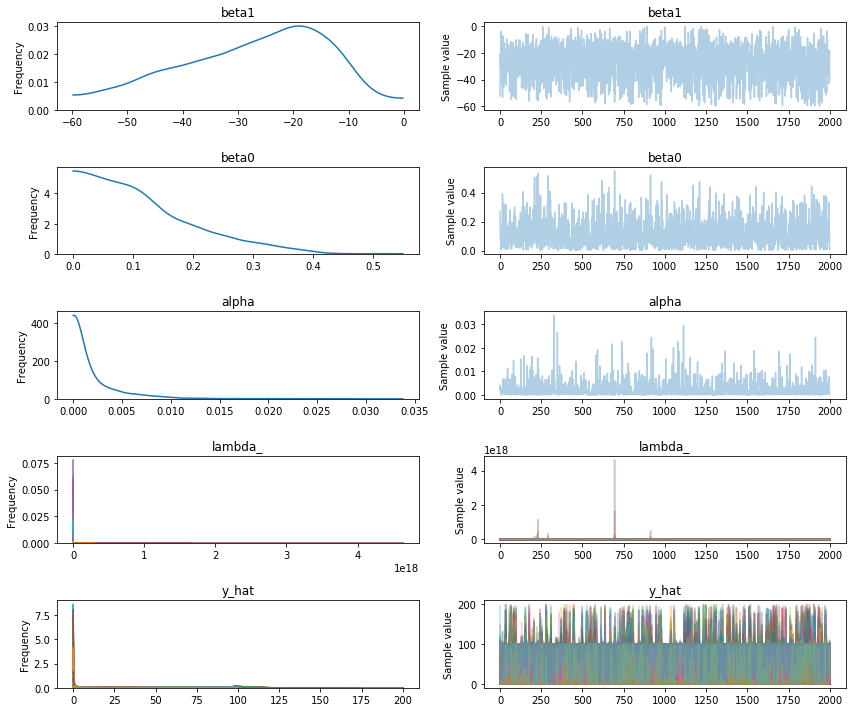

In [9]:
pm.traceplot(trace);
print("beta0 mean a quasi posteriori : ", trace['beta0'].mean())
print("beta1 mean a quasi posteriori : ", trace['beta1'].mean())
print("alpha mean a quasi posteriori : ", trace['alpha'].mean())

# Bayesian approach on the same model (and same data)

In [10]:
with pm.Model() as exponential_bayesian:
    #beta0 = pm.Uniform('beta0', -1., 1.)
    beta1 = pm.Uniform('beta1', -60., 0.)
    
    beta0 = pm.Gamma('beta0', alpha= 1, beta = 10)
    #beta1 = pm.Normal('beta1', mu=beta_true[1]+2, tau=40)
    
    lambda_ = pm.Deterministic('lambda_', T.exp(beta0 * data.a + beta1*data.b))
    
    def logp(failure, value):
        out = value*(T.log(lambda_) - lambda_*failure) - (1-value)*lambda_*failure
        return out.sum()

    exp_surv = pm.DensityDist('exp_surv', logp, observed={'failure':Y.time, 'value':delta_list})

In [11]:
n_samples = 100000
burn = 40000
thin = 60

with exponential_bayesian:
    step = pm.Metropolis()
    trace = pm.sample(n_samples, step)
    
trace = trace[burn::thin]

100%|██████████| 100500/100500 [00:43<00:00, 2327.78it/s]


beta0 mean a posteriori :  9.75178439527e-05
beta1 mean a posteriori :  -7.26156732354


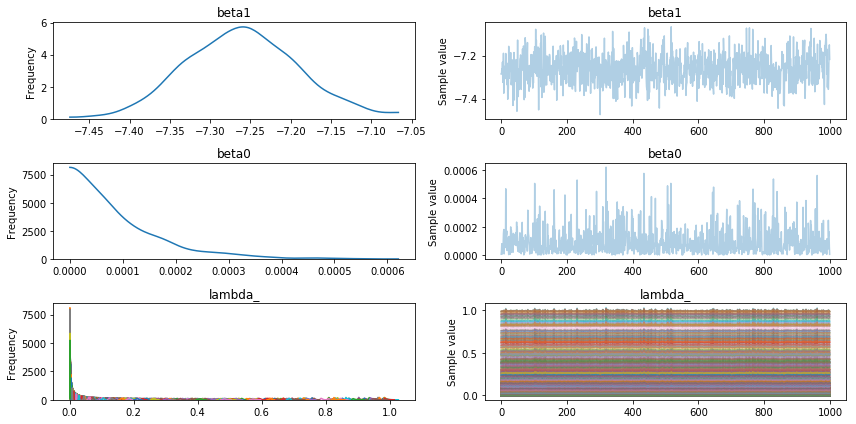

In [12]:
pm.traceplot(trace);
print("beta0 mean a posteriori : ", trace['beta0'].mean())
print("beta1 mean a posteriori : ", trace['beta1'].mean())